In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from pathlib import Path

from zipfile import ZipFile

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
rating = "ratings.csv"

In [6]:
df = pd.read_csv(rating)

In [7]:
# encode the users and movies as indices

# for users
user_id = df['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

# for movies
movie_id = df['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_id)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_id)}

# create a new column for user
df['user'] = df['userId'].map(user_to_user_encoded)

# create a new column for movie
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

In [8]:
# check number of users and movie
num_users = len(user_to_user_encoded)
num_movies = len(movie_to_movie_encoded)

In [9]:
# convert rating to float32
df['rating'] = df['rating'].values.astype(np.float32)

In [10]:
# create a min and max rating
min_rating = min(df['rating'])
max_rating = max(df['rating'])

In [11]:
# examine the data after preprocessing
print('Number of users: {}'.format(num_users))
print('Number of movies: {}'.format(num_movies))
print('Min Rating: {}'.format(min_rating))
print('Max Rating: {}'.format(max_rating))

Number of users: 610
Number of movies: 9724
Min Rating: 0.5
Max Rating: 5.0


In [12]:
df.head(10)

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
5,1,70,3.0,964982400,0,5
6,1,101,5.0,964980868,0,6
7,1,110,4.0,964982176,0,7
8,1,151,5.0,964984041,0,8
9,1,157,5.0,964984100,0,9


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float32
 3   timestamp  100836 non-null  int64  
 4   user       100836 non-null  int64  
 5   movie      100836 non-null  int64  
dtypes: float32(1), int64(5)
memory usage: 4.2 MB


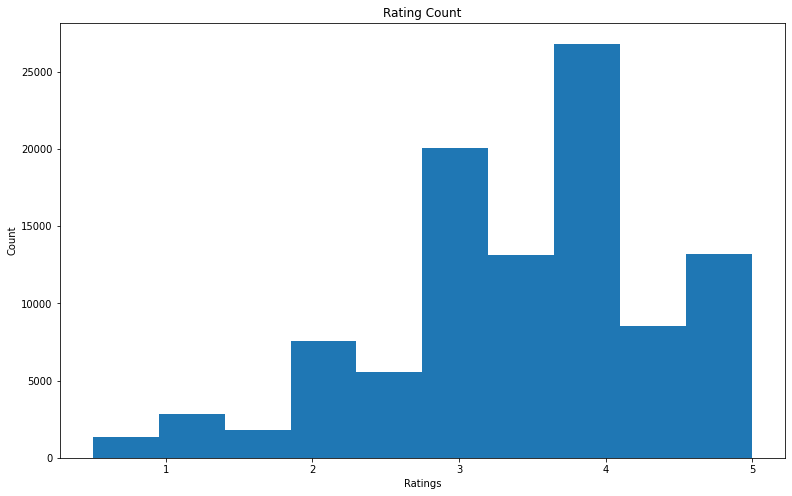

In [14]:
# examine the rating counts
plt.figure(figsize=(13,8))
plt.hist(df['rating'])
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Rating Count')
plt.show()

In [15]:
# return a random of samples of the dataframe
df = df.sample(frac=1, random_state=42)

In [16]:
# create x and y values from the dataframe
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [17]:
# use 70% of the data for training
train_indices = int(0.7 * df.shape[0])

In [18]:
# set up the data for training and validation
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [19]:
# embed users and movies into vectors
# the match score is computed between the users movies by a dot product
# the match score is scale to 0 - 1 interval by a sigmoid

# n-dimensional vector, n = 50 in this case
embedding = 50

class MovieRecommender(keras.Model):
    
    def __init__(self, num_users, num_movies, embedding, **kwargs):
        super(MovieRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding = embedding
        self.user_embedding = layers.Embedding(num_users, embedding, embeddings_initializer="he_normal", embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(num_movies, embedding, embeddings_initializer="he_normal", embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.movie_bias = layers.Embedding(num_movies, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias = self.user_bias(inputs[:,0])
        movie_vector = self.movie_embedding(inputs[:,1])
        movie_bias = self.movie_bias(inputs[:,1])
        d_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        
        # add the user bias, movie bias and the dot product
        x = user_bias + movie_bias + d_user_movie 
        
        # the rating is between 0 and 1
        return tf.nn.sigmoid(x)

In [20]:
# create a model with number of users, movies and n-dimensional vector
model = MovieRecommender(num_users, num_movies, embedding)

# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

In [21]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
1103/1103 [==============================] - 8s 5ms/step - loss: 0.6409 - val_loss: 0.6208
Epoch 2/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6164 - val_loss: 0.6232
Epoch 3/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6104 - val_loss: 0.6148
Epoch 4/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6080 - val_loss: 0.6132
Epoch 5/10
1103/1103 [==============================] - 6s 6ms/step - loss: 0.6068 - val_loss: 0.6110
Epoch 6/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6065 - val_loss: 0.6112
Epoch 7/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6066 - val_loss: 0.6092
Epoch 8/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6051 - val_loss: 0.6106
Epoch 9/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.6051 - val_loss: 0.6089
Epoch 10/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.604

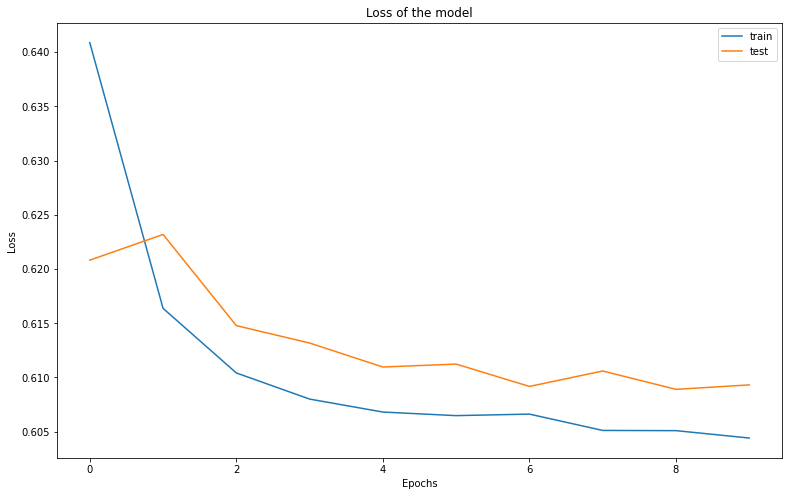

In [22]:
# plot the training and validation data

plt.figure(figsize=(13,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of the model')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
# load the dataset
movie_df = pd.read_csv('movies.csv')

In [27]:
# pick a user and see the recommendations
user_id = df.userId.sample(1).iloc[0]
movies_user_watched = df[df.userId == user_id]
movies_user_not_watched = movie_df[movie_df['movieId'].isin(movies_user_watched.movieId.values)]['movieId']
movies_user_not_watched = list(set(movies_user_not_watched).intersection(set(movie_to_movie_encoded.keys())))
movies_user_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_user_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_user_not_watched), movies_user_not_watched))

ratings = model.predict(user_movie_array).flatten()
top_ratings = ratings.argsort()[-10:][::-1]

recommend_movies_id = [movie_encoded_to_movie.get(movies_user_not_watched[x][0]) for x in top_ratings]

print("Recommended Movies for user: {}".format(user_id))
print('\n')
print('Highly Rated Movies by user')
print('\n')
top_movies_rated = (movies_user_watched.sort_values(by='rating', ascending=False).head(5).movieId.values)
movie_rows = movie_df[movie_df['movieId'].isin(top_movies_rated)]

for row in movie_rows.itertuples():
    print(row.title, "-", row.genres)
    
print('\n')
print('Top 10 Recommended Movies')
print('\n')
recommended_movies = movie_df[movie_df['movieId'].isin(recommend_movies_id)]
for row in recommended_movies.itertuples():
    print(row.title, "-", row.genres)

Recommended Movies for user: 96


Highly Rated Movies by user


Terminator 2: Judgment Day (1991) - Action|Sci-Fi
Aliens (1986) - Action|Adventure|Horror|Sci-Fi
L.A. Confidential (1997) - Crime|Film-Noir|Mystery|Thriller
Commitments, The (1991) - Comedy|Drama|Musical
Thelma & Louise (1991) - Adventure|Crime|Drama


Top 10 Recommended Movies


Usual Suspects, The (1995) - Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope (1977) - Action|Adventure|Sci-Fi
Pulp Fiction (1994) - Comedy|Crime|Drama|Thriller
Schindler's List (1993) - Drama|War
Godfather, The (1972) - Crime|Drama
Reservoir Dogs (1992) - Crime|Mystery|Thriller
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) - Action|Adventure
Godfather: Part II, The (1974) - Crime|Drama
Saving Private Ryan (1998) - Action|Drama|War
Matrix, The (1999) - Action|Sci-Fi|Thriller
